<a href="https://colab.research.google.com/github/SohamSen21/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install pygifsicle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import os
from google.colab import files

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import imageio
import pygifsicle

In [46]:
os.makedirs('results', exist_ok = True)

In [47]:
image_size = 512
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)])

In [48]:

def load_image(path, transform):
    image = Image.open(path)
    image = transform(image)
    return image

In [49]:
uploaded = files.upload()

Saving Great-Pyrenees.jpg to Great-Pyrenees (2).jpg


In [50]:
content_image = load_image('Great-Pyrenees.jpg', transform)


In [51]:
uploaded = files.upload()

Saving Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg to Van_Gogh_-_Starry_Night_-_Google_Art_Project (1).jpg


In [52]:
style_image = load_image('Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', transform)


In [53]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [54]:
def show_image(image):
    image = image.detach().clone()
    image = normalize_image(image)
    image = image.cpu().permute(1,2,0).numpy()
    plt.imshow(image)

In [23]:

def save_image(name, image):
    image = image.detach().clone()
    image = normalize_image(image)
    image = image.cpu().permute(1,2,0).numpy()
    plt.imsave(name, image)

In [55]:
def get_content_loss(features, target):
    loss = F.mse_loss(features, target.detach())
    return loss

In [56]:
def get_gram_matrix(x):
    b, c, h, w = x.shape
    x = x.view(b * c, h * w)
    g = torch.mm(x, x.t())
    g = g.div(b * c * h * w)
    return g


In [57]:

def get_style_loss(features, target):
    g_features = get_gram_matrix(features)
    g_target = get_gram_matrix(target)
    loss = F.mse_loss(g_features, g_target.detach())
    return loss

In [58]:
def get_tv_loss(x):
    diff_1 = x[:, :, :, 1:] - x[:, :, :, :-1]
    diff_2 = x[:, :, 1:, :] - x[:, :, :-1, :]
    var_1 = torch.sum(torch.abs(diff_1))
    var_2 = torch.sum(torch.abs(diff_2))
    return var_1 + var_2

In [59]:
vgg = models.vgg19(pretrained = True).features.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
class VGG(nn.Module):
    def __init__(self, vgg, content_layers, style_layer):
        super().__init__()
        assert isinstance(vgg, nn.Sequential)
        self.content_layers = set(content_layers)
        self.style_layers = set(style_layers)
        max_layers = max(max(content_layers), max(style_layers))
        self.vgg = vgg[:max_layers+1]

    def forward(self, x):
        content_features = []
        style_features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in content_layers:
                content_features.append(x)
            if i in style_layers:
                style_features.append(x)
        return content_features, style_features

In [61]:

content_layers = [7]
style_layers = [0, 2, 5, 7, 10]

In [62]:
model = VGG(vgg, content_layers, style_layers)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:

model = model.to(device)
content_image = content_image.to(device)
style_image = style_image.to(device)

In [65]:
input_image = content_image.clone().requires_grad_()

In [66]:

optimizer = optim.LBFGS([input_image])

In [67]:

content_image = content_image.unsqueeze(0)
style_image = style_image.unsqueeze(0)
input_image = input_image.unsqueeze(0)

In [68]:
n_steps = 100
content_weight = 1
style_weight = 1e6
tv_weight = 1e-6


100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


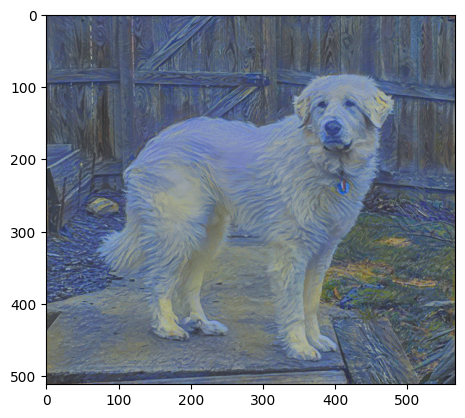

In [69]:

for i in tqdm(range(n_steps)):

    def closure():

        optimizer.zero_grad()

        content_content_features, content_style_features = model(content_image)
        style_content_features, style_style_features = model(style_image)
        input_content_features, input_style_features = model(input_image)

        content_loss = 0

        for input_features, content_features in zip(input_content_features, content_content_features):
            content_loss += get_content_loss(input_features, content_features)

        style_loss = 0

        for input_features, style_features in zip(input_style_features, style_style_features):
            style_loss += get_style_loss(input_features, style_features)

        tv_loss = get_tv_loss(input_image)

        content_loss = content_weight * content_loss
        style_loss = style_weight * style_loss
        tv_loss = tv_weight * tv_loss

        loss = content_loss + style_loss + tv_loss

        loss.backward()

        return loss

    optimizer.step(closure)

    show_image(input_image.squeeze())
    save_image(f'results/image-{i+1}.png', input_image.squeeze())

In [70]:

images = []

In [71]:

file_names = [f'results/image-{i+1}.png' for i in range(n_steps)]

In [72]:
for file_name in file_names:
    images.append(imageio.imread(file_name))
imageio.mimsave('results/image-animated.gif', images)

<ipython-input-72-77b00c3d3203>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


In [77]:
from pygifsicle import optimize

In [78]:
!sudo apt-get install gifsicle

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  gifsicle
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 135 kB of archives.
After this operation, 401 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 gifsicle amd64 1.92-2 [135 kB]
Fetched 135 kB in 0s (502 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package gifsicle.
(Reading database ... 123069 files and directories currently 

In [79]:
pygifsicle.optimize('results/image-animated.gif')